# Thesis

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Adam
from abc import ABC, abstractmethod
from random import choice
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [2]:
class Environment(ABC):
    @abstractmethod
    def next_state(self):
        ...
    
    @abstractmethod
    def reset(self):
        ...

In [3]:
class GridWorld(Environment):
    VELOCITIES = [-1, 0, 1]
    
    def __init__(self, x, y):
        assert x >= 2 and y >= 2, f"GridWorld must be at least 2x2, got {x}x{y}"
        assert isinstance(x, int) and isinstance(y, int), f"Dimensions must be integers, got type(x)={type(x)} and type(y)={type(y)}"
        self.states = np.arange(x*y).reshape(x, y)
        self.reset()
    
    def reset(self):
        self.state = np.random.choice(self.states.flatten())
    
    def next_state(self):
        x, y = np.where(self.states == self.state)
        vx, vy = self.possible_velocity(x.item(), y.item())
        x += vx
        y += vy
        self.state = self.states[x, y].item()
    
    def possible_velocity(self, x, y):
        vx = choice(self.VELOCITIES[int(x == 0):-1 if x == self.states.shape[0] - 1 else len(self.VELOCITIES)])
        vy = choice(self.VELOCITIES[int(y == 0):-1 if y == self.states.shape[1] - 1 else len(self.VELOCITIES)])
        return vx, vy

In [4]:
class ToroidalGridWorld(GridWorld):
    def next_state(self):
        old = self.state
        x, y = np.where(self.states == old)
        vx, vy = self.possible_velocity()
        x = (x + vx) % self.states.shape[0]
        y = (y + vy) % self.states.shape[1]
        self.state = self.states[x, y].item()
        return old, vx, vy, self.state
    
    def possible_velocity(self):
        return choice(self.VELOCITIES), choice(self.VELOCITIES)

In [5]:
from skimage.draw import line_aa
from scipy.stats import multivariate_normal

In [6]:
def get_grid_cell(period, res=400):
    angle = np.random.uniform(0, 2 * np.pi / 3)
    radius = np.ceil(res * 0.9).astype(int) # Should be radius > resolution / sqrt(2)
    
    lines = lines_at_60(angle, period, radius)
    lines = [zeros_with_line(*line_aa(*l), shape=[2 * radius + 1] * 2) for l in lines]
    
    image = np.sum(lines, axis=0) > 1
    image = clean_image(image)
    image = convolve(image, get_gaussian_kernel(int(np.ceil(1.5 * period))))
    
    phase_range = (radius - res // 2) // 2
    phase = np.random.randint(-phase_range, phase_range + 1, 2)
    image = crop_and_add_phase(image, res, phase)
    
    return image / image.max()

def lines_at_60(angle, period, radius):
    lines, l = list(), 0
    while l < radius:
        shift = np.arcsin(l / radius)
        x1, y1 = coords_on_circle(angle + shift, radius=radius)
        x2, y2 = coords_on_circle(angle + np.pi - shift, radius=radius)
        lines.append((x1 + radius, y1 + radius, x2 + radius, y2 + radius))
        if l > 0:
            x1, y1 = coords_on_circle(angle - shift, radius=radius)
            x2, y2 = coords_on_circle(angle + np.pi + shift, radius=radius)
            lines.append((x1 + radius, y1 + radius, x2 + radius, y2 + radius))
            x1, y1 = coords_on_circle(angle + np.pi / 3 + shift, radius=radius)
            x2, y2 = coords_on_circle(angle + np.pi / 3 + np.pi - shift, radius=radius)
            lines.append((x1 + radius, y1 + radius, x2 + radius, y2 + radius))
        x1, y1 = coords_on_circle(angle + np.pi / 3 - shift, radius=radius)
        x2, y2 = coords_on_circle(angle + np.pi / 3 + np.pi + shift, radius=radius)
        lines.append((x1 + radius, y1 + radius, x2 + radius, y2 + radius))
        l += period
    return lines

def coords_on_circle(angle, radius=1):
    lin = radius * np.e**(1j * angle)
    y, x = np.ceil([lin.real, lin.imag]).astype(int)
    return x, y

def zeros_with_line(rr, cc, val=1, shape=None):
    if shape is None:
        shape = (rr.max() + 1, cc.max() + 1)
    z = np.zeros(shape)
    z[rr, cc] = val
    return z

# Remove duplicated intersection points.
# Bad intersections can be of the following forms:
# [[1, 0],  |  [[0, 1],  \  [[1, 1]]  |  [[1],
#  [0, 1]]  \   [1, 0]]  |            \   [1]]
def clean_image(image):
    image[np.where(image[:, :-1] & image[:, 1:])] = False
    image[np.where(image[:-1] & image[1:])] = False
    image[np.where(image[1:, 1:] & image[:-1, :-1])] = False
    rr, cc = np.where(image[1:, :-1] & image[:-1, 1:])
    image[rr + 1, cc] = False
    return image

def convolve(image, kernel):
    shape = np.asarray(kernel.shape) // 2 + image.shape
    image = np.fft.rfft2(image, shape) * np.fft.rfft2(kernel, shape)
    image = np.fft.irfft2(image)
    return np.where(np.isclose(image, 0, atol=1e-4), 0, image)[kernel.shape[0] // 2:, kernel.shape[1] // 2:]
    
def get_gaussian_kernel(res, lower=-5, upper=5):
    x, y = np.linspace(lower, upper, res), np.linspace(lower, upper, res)
    xx, yy = np.meshgrid(x, y)
    coords = np.concatenate([xx[:,:,np.newaxis], yy[:,:,np.newaxis]], axis=-1)
    return grid(coords, [multivariate_normal([0, 0], cov=np.eye(2))])

def grid(coords, distributions):
    shape = coords.shape[:2]
    return np.asarray([dist.pdf(coords.reshape(-1, 2)).reshape(*shape)
                       for dist in distributions]).sum(axis=0) / len(distributions)

def crop_and_add_phase(image, res, phase):
    x, y = image.shape
    x, y = (x - res) // 2 + phase[0], (y - res) // 2 + phase[1]
    return image[x:x + res, y:y + res]

def dist(w, probs, place):
    return np.sum((probs.T @ w - place)**2 * (place + 0.1))

In [97]:
class GridCellWorld(Environment):
    def __init__(self, grid_cells, coords, max_velocity=None):
        self.grid_cells = grid_cells
        self.coords = coords
        self.bounds = (self.coords.min(), self.coords.max())
        self.max_velocity = np.array(self.bounds) / 10 if max_velocity is None else max_velocity
    
    def reset(self, end_point=None, end_radius=None):
        dim = self.coords.shape[-1]
        self.end_point = np.zeros(dim) if end_point is None else end_point
        self.end_radius = np.diff(self.bounds).item() / 100 if end_radius is None else end_radius
        self.velocity = np.zeros(dim)
        self.state = np.random.uniform(*self.bounds, dim)
        while self.done():
            self.state = np.random.uniform(*self.bounds, dim)
        return np.concatenate([self.velocity, self.grid_cells[self.closest_coord_index(self.state)]])
        
    def next_state(self, acceleration):
        self.velocity = np.clip(self.velocity + acceleration, *self.max_velocity)
        self.state = np.clip(self.state + self.velocity, *self.bounds)
        done = self.done()
        reward = 0 if done else self.reward()
        state = np.concatenate([self.velocity, self.grid_cells[self.closest_coord_index(self.state)]])
        return state, reward, done
    
    def closest_coord_index(self, coord):
        return np.unravel_index(np.abs(self.coords - coord).sum(axis=-1).argmin(), self.coords.shape[:2])
    
    def done(self):
        return np.sum((self.state - self.end_point)**2) <= self.end_radius**2
    
    def reward(self):
        dim = self.coords.shape[-1]
        corners = np.array(np.meshgrid(*[self.bounds] * dim)).T.reshape(-1, dim)
        max_dist = np.sum((self.end_point - corners)**2, axis=-1).max()
        
        return -np.sum((self.state - self.end_point)**2) / max_dist

In [8]:
resolution = 400
MIN, MAX = -1, 1
N = 10


x, y = np.linspace(MIN, MAX, resolution), np.linspace(MIN, MAX, resolution)
xx, yy = np.meshgrid(x, y)
coords = np.concatenate([xx[:,:,np.newaxis], yy[:,:,np.newaxis]], axis=-1)


grid_cells = np.asarray([get_grid_cell(period, res=resolution)
                         for period in np.linspace(40, 150, 11)
                         for _ in range(N)]).transpose(1, 2, 0)

# Purge delinquent cells
means = grid_cells.mean(axis=(1, 2))
grid_cells = grid_cells[~(means < means.mean() - means.std() * 4)]

In [98]:
gcw = GridCellWorld(grid_cells, coords)

In [15]:
from copy import deepcopy
from collections import deque

In [99]:
to_tensor = lambda x: torch.tensor(x, device=device, dtype=torch.float32)
    

def sample_episode(env, policy, max_length=100):
    states, actions, rewards, states_new, dones = (list() for _ in range(5))
    
    s = env.reset()
    for _ in range(max_length):
        a = policy(to_tensor(s)).detach().cpu().numpy()
        s_new, r, done = env.next_state(a)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        states_new.append(s_new)
        dones.append(done)
        if done: break
    return (states, actions, rewards, states_new, dones), len(states)

In [100]:
hidden = 100
max_acceleration = 0.05

net = nn.Sequential(
    nn.Linear(grid_cells.shape[-1] + 2, hidden),
    nn.Sigmoid(),
    nn.Linear(hidden, 2),
    nn.Tanh()
).to(device)
net_ = deepcopy(net)

Q = nn.Sequential(
    nn.Linear(grid_cells.shape[-1] + 4, 2 * hidden),
    nn.ReLU(),
    nn.Linear(2 * hidden, 2 * hidden),
    nn.ReLU(),
    nn.Linear(2 * hidden, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 1),
).to(device)
Q_ = deepcopy(Q)

policy = lambda x: net(x) * max_acceleration

optim_policy = Adam([p for p in net.parameters() if p.requires_grad], lr=1e-5, weight_decay=1e-4)
optim_q = Adam([p for p in Q.parameters() if p.requires_grad], lr=2e-5, weight_decay=1e-4)

In [101]:
replay_buffer = deque(maxlen=1000)
bs = 128

while len(replay_buffer) < bs:
    episode, _ = sample_episode(gcw, policy)
    replay_buffer.extend(zip(*episode))

In [102]:
batch = sample(replay_buffer, bs)
batch

[(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.70454875e-01,
         3.78959944e-03, 3.60567724e-01, 0.00000000e+00, 2.17046986e-03,
         1.52398048e-03, 1.06341767e-01, 0.00000000e+00, 1.04045382e-03,
         1.41885730e-02, 1.08416963e-01, 4.11360708e-01, 1.63781677e-01,
         1.08063138e-02, 6.73108288e-03, 2.15158453e-02, 6.80292142e-02,
         2.46155729e-01, 4.89676025e-03, 5.28668439e-01, 1.98975683e-01,
         8.33653207e-03, 1.25961250e-02, 3.21832275e-02, 6.29409119e-04,
         5.36549808e-03, 1.04466549e-03, 2.85992738e-02, 1.29228613e-02,
         2.17960639e-01, 0.00000000e+00, 1.16495565e-02, 1.17421074e-03,
         2.04525404e-03, 9.28511897e-03, 3.28050981e-02, 0.00000000e+00,
         1.26118570e-01, 2.79223415e-03, 2.13720924e-03, 2.50635147e-02,
         1.22447076e-02, 0.00000000e+00, 4.69259497e-02, 1.80850154e-02,
         4.87628859e-02, 1.84506082e-03, 7.51178150e-04, 6.38904684e-01,
         9.52882079e-03, 3.70267415e-03, 4.68238255

In [60]:
np.vstack(df.to_numpy()[2])

(128, 1)

In [572]:
losses_pol, losses_q, lengths = [], [], []
for ep in tqdm(range(100)):
    batch = sample(replay_buffer, bs)
    for s, _, r, _, sn in reversed(list(zip(*episode))):
        optim_policy.zero_grad()
        
        s, sn = to_tensor(s), to_tensor(sn)
        a, an = policy(s), policy(sn)
        q = Q(torch.concat([s, a]))
        
        loss_pol = -q
        loss_pol.backward(retain_graph=True)
        optim_policy.step()
        losses_pol.append(loss_pol.detach().cpu().item())
        
        optim_q.zero_grad()
        qn = Q(torch.concat([sn, an]))
        G = (r + qn - q).detach().item()**2
        loss_q = -G * q
        loss_q.backward()
        optim_q.step()
        losses_q.append(loss_q.detach().cpu().item())
    episode, length = sample_episode(gcw, policy)
    replay_buffer.extend(zip(*episode))
    lengths.append(length)
    
    # loss.backward()
    # optim.step()
    # losses.append(loss.detach().cpu().item())
    # print(loss.detach().cpu().item())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


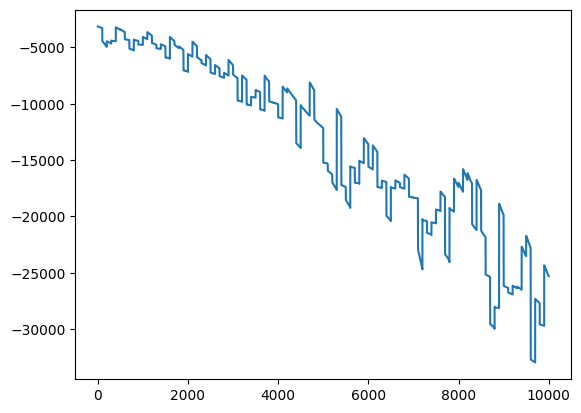

In [573]:
plt.plot(losses_pol)

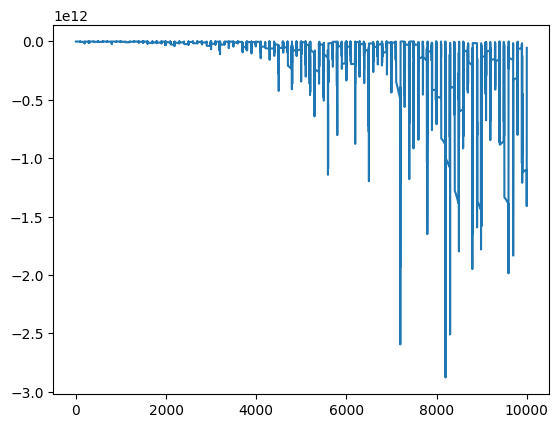

In [574]:
plt.plot(losses_q)

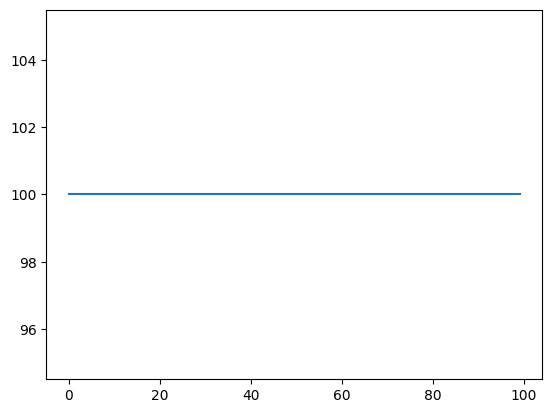

In [575]:
plt.plot(lengths)